In [108]:
## import all required modules
import os, glob
import numpy as np
import pickle
# for plotting
import matplotlib
matplotlib.use('Agg')
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
%matplotlib inline

In [144]:
## some auxiliary functions
#
#colors = ['darkkhaki', 'royalblue']
colors = ["midnightblue", "darkorange"]

def val_order(number):
    return int(np.floor(np.log10(number)))
#
# ****************************************************************************************************
#
def get_ngpus(fname, search_str, max_order=3):
    """
    Tries to get numbers in the vicinty of search_str which is supposed to be a substring in fname.
    First seaches for numbers right before the occurence of search_str, then afterwards.
    :param fname: file name from which number should be inferred
    :param search_str: seach string for which number identification is considered to be possible
    :param max_order: maximum order of retrieved number (default: 3 -> maximum number is 999 then)
    :return num_int: integer of number in the vicintity of search string. 
    """
    
    ind_gpu_info = fname.lower().find(search_str)
    if ind_gpu_info == -1:
        raise ValueError("Unable to find search string '{0}' in file name '{1}'".format(search_str, fname))
    
    # init loops
    fname_len = len(fname)
    success, flag = False, True
    indm = 1
    ind_sm, ind_sp = 0, 0
    # check occurence of numbers in front of search string
    while indm < max_order and flag:
        if ind_gpu_info - indm > 0:
            if fname[ind_gpu_info - indm].isnumeric():
                ind_sm += 1
                success = True
            else:
                flag = False
        else:
            flag = False
        indm += 1
    # end while-loop
    if not success: # check occurence of numbers after search string
        ind_gpu_info = ind_gpu_info + len(search_str)
        flag = True
        indm = 0
        while indm < max_order and flag: 
            if ind_gpu_info + indm < fname_len:
                if fname[ind_gpu_info + indm].isnumeric():
                    ind_sp += 1
                    success = True
                else:
                    flag = False
            else:
                flag = False
            indm += 1
        # end while-loop    
        if success:
            return(int(fname[ind_gpu_info:ind_gpu_info+ind_sp]))
        else:
            raise ValueError("Search string found in fname, but unable to infer number of GPUs.")

    else:
        return(int(fname[ind_gpu_info-ind_sm:ind_gpu_info]))
#
# ****************************************************************************************************
#
# functions for computing time
def compute_time_tot(infile):
    with open(infile,'rb') as tfile:
        #print("Opening pickle time: '{0}'".format(infile))
        total_time_sec = pickle.load(tfile)
    return np.asarray(total_time_sec/60)
#
# ****************************************************************************************************
#
def compute_time_tot_log(infile):
    total_time_min = compute_time_tot(infile)
    return np.log(total_time_min)
#
# ****************************************************************************************************
#
def get_time_dict(base, wildcardspec, tfilename, gpu_id_str="gpu", llog = False):
    time_dict = {}
    flist_hpc = sorted(glob.glob(base + wildcardspec))
    print(flist_hpc)
    wrapper = compute_time_tot
    if llog: wrapper = compute_time_tot_log
    for tfile in flist_hpc: 
        ngpus = get_ngpus(tfile, gpu_id_str)
        time_dict["{0:d} GPU(s)".format(ngpus)] = wrapper(tfile + tfilename)
    return time_dict
#
def calc_speedup(comp_time, ngpus, l_ideal= False):
    nn = np.shape(ngpus)[0]
    if l_ideal:
        spd_data = np.array(ngpus, dtype=float)
    else:
        spd_data = comp_time

    spd_up = spd_data[0:nn-1]/spd_data[1::]
    
    if l_ideal: spd_up = 1./spd_up

    return spd_up
#
# ****************************************************************************************************
#
# functions for iteration time data    
def iter_time_mean_std(infile):
    with open(infile, 'rb') as tfile:
        time_per_iteration_list = pickle.load(tfile) 
        
    time_per_iteration = np.array(time_per_iteration_list)
    return np.mean(time_per_iteration), np.std(time_per_iteration)
#
# ****************************************************************************************************
#
def iter_stat(base, wildcardspec, gpu_id_str="gpu"):
    stat_iter_dict = {}
    flist_hpc = sorted(glob.glob(base + wildcardspec))
    for tdir in flist_hpc: 
        ngpus = get_ngpus(tdir, gpu_id_str)
        ftname = os.path.join(tdir, fname_timing_iter)
        mean_loc, std_loc = iter_time_mean_std(ftname)
        stat_iter_dict["{0:d} GPU(s)".format(ngpus)] = {"mean": mean_loc , "std": std_loc}
    return stat_iter_dict
#
# ****************************************************************************************************
#
def read_iter_time(infile):
    with open(infile,'rb') as tfile:
        time_per_iteration_list = pickle.load(tfile)
    return np.asarray(time_per_iteration_list)
#
# ****************************************************************************************************
#
def get_iter_time_all(base, wildcardspec, gpu_id_str="gpu"):
    iter_dict = {}
    flist_hpc = sorted(glob.glob(base + wildcardspec))
    for tdir in flist_hpc: 
        ngpus = get_ngpus(tdir, gpu_id_str)
        ftname = os.path.join(tdir, fname_timing_iter)
        iter_dict["{0:d} GPU(s)".format(ngpus)] = read_iter_time(ftname)
    return iter_dict   
#
# ****************************************************************************************************
#
# functions for plotting
def autolabel(ax, rects, rot=45):
    """Attach a text label above each bar in *rects*, displaying its height."""
    scal = 1
    if rot <0.:
        scal = -1
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width()*scal, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=rot)
#
# ****************************************************************************************************
#
def plot_computation_time(times1, times2, ngpus, names, plt_fname, log_yvals = False):
    
    nlabels = len(ngpus)
    x_pos = np.arange(nlabels)
    
    bar_width = 0.35
    ytitle = "Time [min]"
    max_time = np.maximum(np.max(times1), np.max(times2))
    time_order = val_order(max_time)
    ymax = np.ceil(max_time/(10**time_order) + 0.5)*(10**time_order) + 10**time_order
   # np.ceil(np.maximum(np.max(times1)/100. + 0.5, np.max(times2)/100. + 0.5))*100.
    if log_yvals: 
        times1, times2 = np.log(times1), np.log(times2)
        ytitle = "LOG(Time) [min]"
        ymax = np.ceil(np.maximum(np.max(times1)+0.5, np.max(times2) + 0.5))
    
    # create plot object
    fig, ax = plt.subplots()
    # create data bars
    rects1 = ax.bar(x_pos - bar_width/2, np.round(times1, 2), bar_width, label=names[0], color=colors[0])
    rects2 = ax.bar(x_pos + bar_width/2, np.round(times2, 2), bar_width, label=names[1], color=colors[1])
    # customize plot appearance
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ytitle)
    ax.set_title('Comparison {0} and {1} with convLSTM model'.format(*names))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(ngpus)
    ax.set_xlabel('# GPUs')
    ax.set_ylim(0., ymax)
    ax.legend()
                
    # add labels
    autolabel(ax, rects1)
    autolabel(ax, rects2)
    print("Saving plot in file: {0}.png ...".format(plt_fname))
    plt.savefig(plt_fname+".png")
    plt.close()
#
# ****************************************************************************************************
#
def plot_speedup(comp_time_hpc1, comp_time_hpc2, ngpus, names):
    fig = plt.figure(figsize=(6,4))
    ax = plt.axes([0.1, 0.15, 0.75, 0.75])   
    
    spd_up1 = calc_speedup(comp_time_hpc1, ngpus)
    spd_up2 = calc_speedup(comp_time_hpc2, ngpus)
    spd_ideal= calc_speedup(comp_time_hpc2, ngpus, l_ideal=True)
    
    plt.plot(spd_up1/spd_ideal, label= names[0], c=colors[0], lw=1.5)
    plt.plot(spd_up2/spd_ideal, label= names[1], c=colors[1], lw=1.5)
    plt.plot(spd_ideal/spd_ideal, label= "Ideal", c="r", lw=3.)
    
    xlabels = []
    for i in np.arange(len(ngpus)-1):
        xlabels.append("{0} -> {1}".format(ngpus[i], ngpus[i+1]))
    plt.xticks(np.arange(0, len(ngpus)-1), xlabels)
    ax.set_xlim(-0.5, len(ngpus)-1.5)
    ax.set_ylim(0.5, 1.5)
    legend = ax.legend(loc='upper left')
    ax.set_xlabel('GPU usage')
    ax.set_ylabel('Ratio Speedup factor') 
    
    plt_fname = "speed_up_{0}_vs_{1}.png".format(*names)
    print("Saving plot in file: {0}.png ...".format(plt_fname))
    plt.savefig("speed_up_{0}_vs_{1}.png".format(*names))
#
# ****************************************************************************************************
#
def boxplot_iter_time(time_per_iteration_data1, time_per_iteration_data2, ngpu_list, names):
    nexps = len(ngpu_list)
    # create data lists for boxplot-routine
    data = []
    for i in np.arange(nexps):
        data.append(time_per_iteration_data1["{0} GPU(s)".format(ngpu_list[i])])
        data.append(time_per_iteration_data2["{0} GPU(s)".format(ngpu_list[i])])
     
    # trick to get list with duplicated entries
    xlabels = [val for val in ngpu_list for _ in (0, 1)]

    # Multiple box plots on one Axes
    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(6,4))
    ax = plt.axes([0.1, 0.15, 0.75, 0.75])   
    
    ax.set_title("Time per iteration step")
    bp = ax.boxplot(data, notch=0, sym='+', vert=1, whis=1.5, showfliers=False) # Outliers for initialization are disturbing
    plt.xticks(np.arange(1, nexps*2 +1), xlabels)
    ax.set_xlabel('# GPUs')
    ax.set_ylabel('Time [s]')
    
    # Reference: https://matplotlib.org/3.1.1/gallery/statistics/boxplot_demo.html 
    box_colors = colors
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        box_coords = np.column_stack([boxX, boxY])
        # Alternate between Dark Khaki and Royal Blue
        ax.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        medianX = []
        medianY = []
        for j in range(2):
            medianX.append(med.get_xdata()[j])
            medianY.append(med.get_ydata()[j])
            ax.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax.plot(np.average(med.get_xdata()), np.average(data[i]),
                color='w', marker='*', markeredgecolor='k', markersize=10)
    
    # Finally, add a basic legend
    fig.text(0.86, 0.15, names[0],
             backgroundcolor=box_colors[0], color='white', weight='roman',
             size='small')
    fig.text(0.86, 0.09, names[1],
             backgroundcolor=box_colors[1],
             color='white', weight='roman', size='small')
    #fig.text(0.90, 0.015, '*', color='white', backgroundcolor='silver',
    #         weight='roman', size='medium')
    #fig_transform =  ax.figure.transFigure #+ ax.transAxes.inverted() #+ ax.figure.transFigure.inverted()
    #ax.plot(0.1, 0.03, marker='*', markersize=30, color="w", markeredgecolor="k", transform=fig_transform)
    fig.text(0.86, 0.03, '* Mean', color='black', backgroundcolor='white', 
             weight='roman', size='small', bbox=dict(facecolor='none', edgecolor='k'))

    plt_fname = "boxplot_iter_time_{0}_vs_{1}".format(*names)
    print("Saving plot in file: {0}.png ...".format(plt_fname))
    plt.savefig(plt_fname+".png")
    plt.close()
    
    

In [110]:
## some basic settings
base_dir = "/p/project/deepacf/deeprain/video_prediction_shared_folder/models/era5-Y2007-2019M01to12-92x56-3840N0000E-2t_tcc_t_850/convLSTM_container/"

wildcard_hpc1 = '20210325T095504_langguth1_juwels_container_[1-9]*gpu*'  # search pattern for finding the experiments
wildcard_hpc2 = '20210325T095504_langguth1_jwb_container_[1-9]*gpu*'

gpu_id_str = ["gpu", "gpu"]               # search substring to get the number of GPUs used in the experiments,
                                          # e.g. "gpu" if '64gpu' is a substring in the experiment directory
                                          # or "ngpu" if 'ngpu64' is a substring in the experiment directory
                                          # -> see wilcard-variables above
names_hpc = ["Juwels", "Booster"]

# name of pickle files tracking computing time
fname_timing_train = "/timing_training_time.pkl"
fname_timing_total = "/timing_total_time.pkl"

fname_timing_iter = "timing_per_iteration_time.pkl"


In [111]:
## evaluate computing time
# dictionaries with the total times
tot_time_hpc1_dict = get_time_dict(base_dir, wildcard_hpc1, fname_timing_total, gpu_id_str=gpu_id_str[0])
tot_time_hpc2_dict= get_time_dict(base_dir, wildcard_hpc2, fname_timing_total, gpu_id_str=gpu_id_str[1])

print(tot_time_hpc1_dict)
print(tot_time_hpc2_dict)

# dictionaries with the training times
train_time_hpc1_dict = get_time_dict(base_dir, wildcard_hpc1, fname_timing_train, gpu_id_str=gpu_id_str[0])
train_time_hpc2_dict = get_time_dict(base_dir, wildcard_hpc2, fname_timing_train, gpu_id_str=gpu_id_str[1])

# get sorted arrays
# Note: The times for Juwels are divided by 2, since the experiments have been performed with an epoch number of 20
#       instead of 10 (as Bing and Scarlet did)
ngpus_sort = sorted([int(ngpu.split()[0]) for ngpu in tot_time_hpc1_dict.keys()])
nexps = len(ngpus_sort)
tot_time_hpc1 = np.array([tot_time_hpc1_dict["{0:d} GPU(s)".format(key)] for key in ngpus_sort])
tot_time_hpc1[0] = tot_time_hpc1[0]#*2.
tot_time_hpc2 = np.array([tot_time_hpc2_dict["{0:d} GPU(s)".format(key)] for key in ngpus_sort])

train_time_hpc1 = np.array([train_time_hpc1_dict["{0:d} GPU(s)".format(key)] for key in ngpus_sort])
train_time_hpc1[0] = train_time_hpc1[0]#*2.
train_time_hpc2 = np.array([train_time_hpc2_dict["{0:d} GPU(s)".format(key)] for key in ngpus_sort])

overhead_hpc1 = tot_time_hpc1 - train_time_hpc1
overhead_hpc2= tot_time_hpc2 - train_time_hpc2

['/p/project/deepacf/deeprain/video_prediction_shared_folder/models/era5-Y2007-2019M01to12-92x56-3840N0000E-2t_tcc_t_850/convLSTM_container/20210325T095504_langguth1_juwels_container_16gpus', '/p/project/deepacf/deeprain/video_prediction_shared_folder/models/era5-Y2007-2019M01to12-92x56-3840N0000E-2t_tcc_t_850/convLSTM_container/20210325T095504_langguth1_juwels_container_1gpu', '/p/project/deepacf/deeprain/video_prediction_shared_folder/models/era5-Y2007-2019M01to12-92x56-3840N0000E-2t_tcc_t_850/convLSTM_container/20210325T095504_langguth1_juwels_container_32gpus', '/p/project/deepacf/deeprain/video_prediction_shared_folder/models/era5-Y2007-2019M01to12-92x56-3840N0000E-2t_tcc_t_850/convLSTM_container/20210325T095504_langguth1_juwels_container_4gpus', '/p/project/deepacf/deeprain/video_prediction_shared_folder/models/era5-Y2007-2019M01to12-92x56-3840N0000E-2t_tcc_t_850/convLSTM_container/20210325T095504_langguth1_juwels_container_64gpus', '/p/project/deepacf/deeprain/video_prediction_s

[492.70926997 100.99109779  49.63896298  34.26928383  35.05492661
  30.98471271]
Saving plot in file: ./total_computation_time_Juwels_vs_Booster.png ...
Saving plot in file: ./overhead_time_Juwels_vs_Booster.png ...
Saving plot in file: speed_up_Juwels_vs_Booster.png.png ...


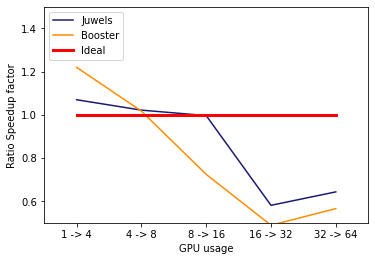

In [112]:
# plot the computing time
print(tot_time_hpc2)
plot_computation_time(tot_time_hpc1, tot_time_hpc2, ngpus_sort, names_hpc, \
                       "./total_computation_time_{0}_vs_{1}".format(*names_hpc), log_yvals=False)

plot_computation_time(overhead_hpc1, overhead_hpc2, ngpus_sort, names_hpc, \
                       "./overhead_time_{0}_vs_{1}".format(*names_hpc))
# plot speed-up factors
plot_speedup(tot_time_hpc1, tot_time_hpc2, ngpus_sort, names_hpc)

In [113]:
## evaluate iteration time
# get iteration times
iter_data_hpc1 = get_iter_time_all(base_dir, wildcard_hpc1, gpu_id_str=gpu_id_str[0])
iter_data_hpc2 = get_iter_time_all(base_dir, wildcard_hpc2, gpu_id_str=gpu_id_str[1])

In [114]:
# plot the iteration time in box plots
boxplot_iter_time(iter_data_hpc1, iter_data_hpc2, ngpus_sort, names_hpc)

Saving plot in file: boxplot_iter_time_Juwels_vs_Booster.png ...


In [115]:
def get_slowiter(iter_time, threshold):
    inds_slow = np.where(iter_time > threshold)[0]
    return iter_time[inds_slow], np.shape(inds_slow)[0]

def ana_slowiter(itertime1, itertime2, thres, names):
    slowt1, nslow1 = get_slowiter(itertime1, thres)
    slowt2, nslow2 = get_slowiter(itertime2, thres)
    
    if nslow1 > 0:
        print("{0:d} slow iteration steps on {1} with averaged time of {2:5.2f}s (max: {3:5.2f}s)"\
              .format(nslow1, names[0], np.mean(slowt1), np.max(slowt1)))
    else: 
        print("No slow iterations on {0}".format(names[0]))
        
    if nslow2 > 0:
        print("{0:d} slow iteration steps on {1} with averaged time of {2:5.2f}s (max: {3:5.2f}s)"\
              .format(nslow2, names[1], np.mean(slowt2), np.max(slowt2)))
    else: 
        print("No slow iterations on {0}".format(names[1]))

In [116]:
    
## settings
names = ["Juwels", "Booster"]
slowiter_time = 5.       # arbitrary threshold for slow iteration steps

# analyze single GPU experiments
print("***** Analyse single GPUs experiments *****")
itertime_juwels = iter_data_hpc1["1 GPU(s)"]
itertime_booster = iter_data_hpc2["1 GPU(s)"]

ana_slowiter(itertime_juwels[1:], itertime_booster[1:], slowiter_time, names)

# analyze 4 GPUs experiments
print("***** Analyse 4 GPUs experiments *****")
itertime_juwels = iter_data_hpc1["4 GPU(s)"]
itertime_booster = iter_data_hpc2["4 GPU(s)"]

ana_slowiter(itertime_juwels[1:], itertime_booster[1:], slowiter_time, names)

# analyze 8 GPUs experiments
print("***** Analyse 8 GPUs experiments *****")
itertime_juwels = iter_data_hpc1["8 GPU(s)"]
itertime_booster = iter_data_hpc2["8 GPU(s)"]

ana_slowiter(itertime_juwels[1:], itertime_booster[1:], slowiter_time, names)

# analyze 16 GPUs experiments
print("***** Analyse 32 GPUs experiments *****")
itertime_juwels = iter_data_hpc1["16 GPU(s)"]
itertime_booster = iter_data_hpc2["16 GPU(s)"]

ana_slowiter(itertime_juwels[1:], itertime_booster[1:], slowiter_time, names)

# analyze 32 GPUs experiments
print("***** Analyse 32 GPUs experiments *****")
itertime_juwels = iter_data_hpc1["32 GPU(s)"]
itertime_booster = iter_data_hpc2["32 GPU(s)"]

ana_slowiter(itertime_juwels[1:], itertime_booster[1:], slowiter_time, names)

# analyze 64 GPUs experiments
print("***** Analyse 64 GPUs experiments *****")
itertime_juwels = iter_data_hpc1["64 GPU(s)"]
itertime_booster = iter_data_hpc2["64 GPU(s)"]

ana_slowiter(itertime_juwels[1:], itertime_booster[1:], slowiter_time, names)

***** Analyse single GPUs experiments *****
1 slow iteration steps on Juwels with averaged time of  5.18s (max:  5.18s)
No slow iterations on Booster
***** Analyse 4 GPUs experiments *****
No slow iterations on Juwels
No slow iterations on Booster
***** Analyse 8 GPUs experiments *****
No slow iterations on Juwels
No slow iterations on Booster
***** Analyse 32 GPUs experiments *****
No slow iterations on Juwels
No slow iterations on Booster
***** Analyse 32 GPUs experiments *****
No slow iterations on Juwels
No slow iterations on Booster
***** Analyse 64 GPUs experiments *****
No slow iterations on Juwels
No slow iterations on Booster


# Summary
- Occasionally, a few iteration steps are slow
- However, performance degradation seems to be much worser on Booster than on Juwels
- Higher chance for slow iteration steps on Booster in general

In [157]:
def boxplot_iter_total_time(iteration_time, total_time, ngpu_list, name, log_yvals=False):
    nexps = len(ngpu_list)
    bar_width = 0.35
    # create data lists for boxplot-routine
    iter_time_all = []
    for i in np.arange(nexps):
        iter_time_all.append(iteration_time["{0} GPU(s)".format(ngpu_list[i])])
     
    # trick to get list with duplicated entries
    xlabels = [val for val in ngpu_list for _ in (0, 1)]
    nlabels = len(xlabels)

    # Multiple box plots on one Axes
    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(6,4))
    ax = plt.axes([0.1, 0.15, 0.75, 0.75])   
    
    bp = ax.boxplot(iter_time_all, positions=np.arange(0, nlabels, 2), notch=0, sym='+', vert=1, showfliers=False, widths=bar_width) # Outliers for initialization are disturbing
    ax.set_xlabel('# GPUs')
    ax.set_ylabel('Time [s]')
    
    # Reference: https://matplotlib.org/3.1.1/gallery/statistics/boxplot_demo.html 
    num_boxes = len(iter_time_all)
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        box_coords = np.column_stack([boxX, boxY])
        ax.add_patch(Polygon(box_coords, facecolor=colors[1]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        medianX = []
        medianY = []
        for j in range(2):
            medianX.append(med.get_xdata()[j])
            medianY.append(med.get_ydata()[j])
            ax.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax.plot(np.average(med.get_xdata()), np.average(iter_time_all[i]),
                color='w', marker='*', markeredgecolor='k', markersize=10)
    
    ax2 = ax.twinx()
    x_pos = np.arange(1, nlabels+1 ,2)
    
    ytitle = "Time [min]"
    max_time = np.max(total_time)
    time_order = val_order(max_time)
    ymax = np.ceil(max_time/(10**time_order) + 0.5)*(10**time_order) + 10**time_order
    # np.ceil(np.maximum(np.max(times1)/100. + 0.5, np.max(times2)/100. + 0.5))*100.
    if log_yvals: 
        total_time = np.log(total_time)
        ytitle = "LOG(Time) [min]"
        ymax = np.ceil(np.max(total_time) + 0.5)
    
    # create data bars
    rects = ax2.bar(x_pos, np.round(total_time, 2), bar_width, label=names, color=colors[0])
    # customize plot appearance
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel(ytitle)
    ax2.set_xticks(np.arange(0, nlabels))
    ax2.set_xticklabels(xlabels)
    ax2.set_xlabel('# GPUs')
    ax2.set_ylim(0., ymax)
                
    # add labels
    autolabel(ax2, rects, rot=45)     

    plt_fname = "iter+tot_time_{0}_vs_{1}".format(*names)
    print("Saving plot in file: {0}.png ...".format(plt_fname))
    #plt.show()
    plt.savefig(plt_fname+".png")
    plt.close()
    


In [158]:
boxplot_iter_total_time(iter_data_hpc2, tot_time_hpc2, ngpus_sort, names_hpc[1])

Saving plot in file: iter+tot_time_Juwels_vs_Booster.png ...
